## Import Packages

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set figure size for plots
rcParams['figure.figsize'] = 12, 6

## Model Selection and Training

In [2]:
data_file_path = '../data/preprocessed/merged_oil_exchange_full.csv'
preprocessed_data_dir_path = '../data/preprocessed'

ts_end_column = 'avg_oil_pricing'
ts_exg_column = 'usd_exchange_rate'

data = pd.read_csv(data_file_path, parse_dates=['date'], index_col='date')

ts_end_diff = np.load(os.path.join(preprocessed_data_dir_path, 'end_diff.npy'))
ts_exg_diff = np.load(os.path.join(preprocessed_data_dir_path, 'exg_diff.npy'))
ts_end_seasonal_diff = np.load(os.path.join(preprocessed_data_dir_path, 'end_seasonal_diff.npy'))
ts_exg_seasonal_diff = np.load(os.path.join(preprocessed_data_dir_path, 'exg_seasonal_diff.npy'))

**Model Selection**: determining appropriate values for p, d, and q. This is typically done by analyzing the ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots.

- **p**: order of the AR term - *number of lagged observations*
- **q**: the degree of differencing -*number of times the data is differencing*
- **r**: the order of the MA term - *size of the moving average window*

### Parameter optimization
Grid search and information criteria

In [3]:
def optimize_arima_parameters(endog, exog, p_range, d_range, q_range):
    best_aic = float("inf")
    best_params = None
    best_model = None

    total_iterations = len(p_range) * len(d_range) * len(q_range)
    print(f"Testing {total_iterations} ARIMA configurations")

    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(endog=endog, exog=exog, order=(p, d, q))
                    results = model.fit()

                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q)
                        best_model = results
                        print(f"ARIMA({p},{d},{q}) - AIC: {results.aic}")
                except:
                    continue
    print(f"\nBest ARIMA{best_params} model - AIC: {best_aic}")
    return best_model, best_params

In [6]:
non_seasonal_arima, params = optimize_arima_parameters(
    ts_end_diff, 
    ts_exg_diff,
    p_range=range(0, 6),
    d_range=range(0, 2), 
    q_range=range(0, 6) 
)

Testing 72 ARIMA configurations
ARIMA(0,0,0) - AIC: -315.69627605941804
ARIMA(0,0,2) - AIC: -322.7393480635775
ARIMA(4,0,4) - AIC: -325.13294945406994

Best ARIMA(4, 0, 4) model - AIC: -325.13294945406994


In [8]:
seasonal_arima, params = optimize_arima_parameters(
    ts_end_seasonal_diff, 
    ts_exg_seasonal_diff,
    p_range=range(0, 6),
    d_range=range(0, 2), 
    q_range=range(0, 6) 
)

Testing 72 ARIMA configurations
ARIMA(0,0,0) - AIC: 24.318907553217546
ARIMA(0,0,1) - AIC: -83.09201480260903
ARIMA(0,0,2) - AIC: -170.47706169782475
ARIMA(0,0,3) - AIC: -190.48815151053697
ARIMA(0,0,4) - AIC: -220.3016378033576
ARIMA(0,1,0) - AIC: -230.70119720783765
ARIMA(0,1,2) - AIC: -235.31596119837783
ARIMA(0,1,3) - AIC: -236.2484455368717
ARIMA(0,1,4) - AIC: -243.78916441527716
ARIMA(1,0,4) - AIC: -246.88021269315055
ARIMA(3,0,4) - AIC: -250.4870043787758
ARIMA(4,0,5) - AIC: -252.3151080408129

Best ARIMA(4, 0, 5) model - AIC: -252.3151080408129


While **not strictly required**, normally distributed residuals are generally desirable for certain statistical tests and inferences

In [4]:
def validate_model(model):
    residuals = pd.DataFrame(model.resid)
    
    plt.figure(figsize=(14, 7))
    plt.plot(residuals)
    plt.title('Residuals')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(14, 7))
    residuals.plot(kind='kde')
    plt.title('Residuals Density Plot')
    plt.grid(True)
    plt.show()
    
    print("Residuals Summary Statistics:")
    print(residuals.describe())
    
    # Perform Ljung-Box test to check for autocorrelation in residuals
    from statsmodels.stats.diagnostic import acorr_ljungbox
    lb_test = acorr_ljungbox(residuals, lags=10)
    
    print("\nLjung-Box Test Results:")
    print(pd.DataFrame({
        'Test Statistic': lb_test['lb_stat'],
        'p-value': lb_test['lb_pvalue']
    }))
    
    # Check for normality of residuals (Shapiro-Wilk test)
    shapiro_test = stats.shapiro(residuals)
    print("\nShapiro-Wilk Test for Normality:")
    print(f"Test Statistic: {shapiro_test[0]}")
    print(f"p-value: {shapiro_test[1]}")
    if shapiro_test[1] > 0.05:
        print("Residuals appear to be normally distributed")
    else:
        print("Residuals do not appear to be normally distributed")

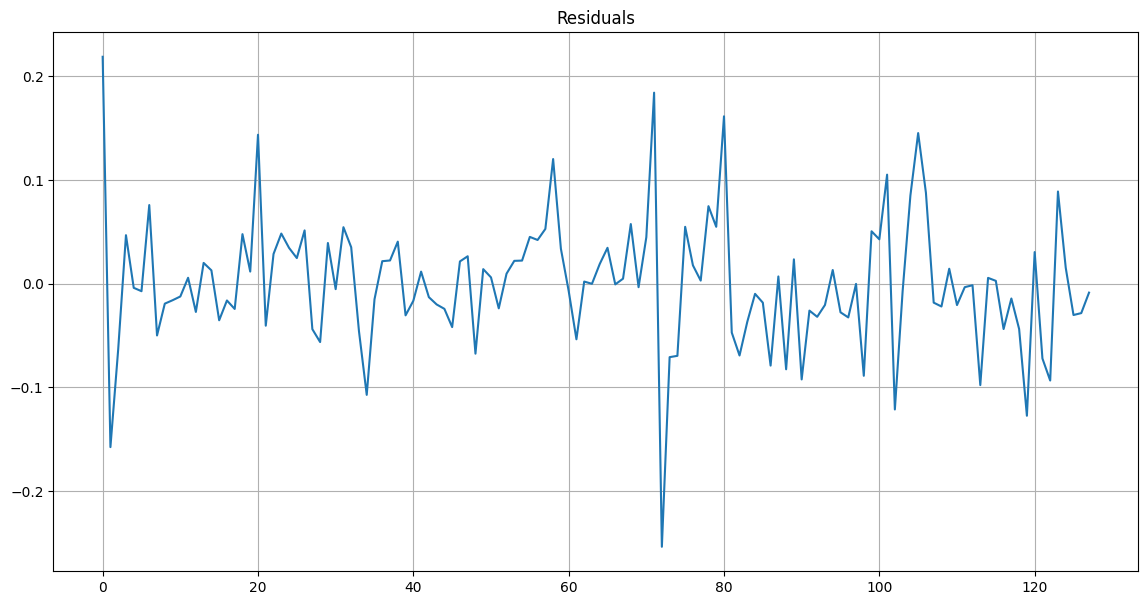

<Figure size 1400x700 with 0 Axes>

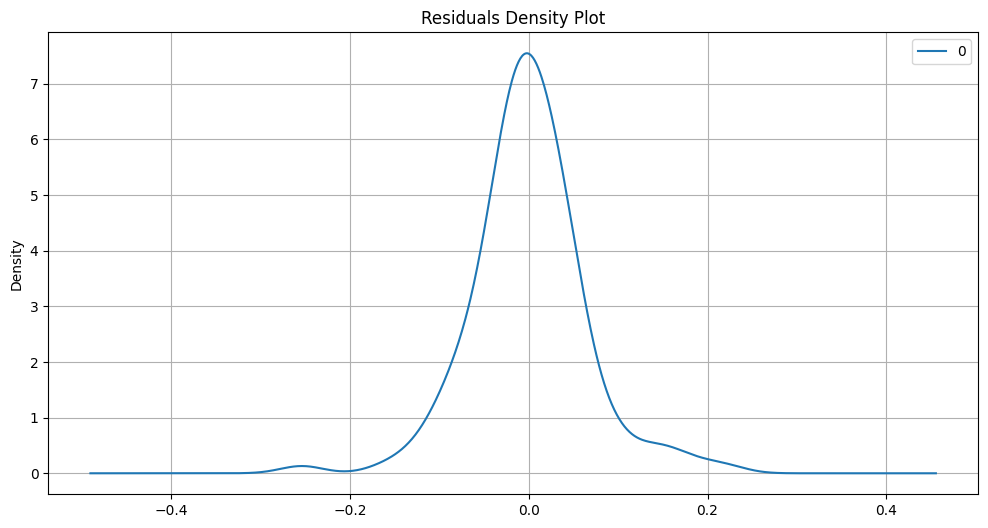

Residuals Summary Statistics:
                0
count  128.000000
mean    -0.000057
std      0.063160
min     -0.253714
25%     -0.030231
50%     -0.001007
75%      0.031371
max      0.218958

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.008530  0.926413
2         0.178056  0.914820
3         0.200115  0.977571
4         0.243358  0.993171
5         0.618639  0.987134
6         1.475588  0.961100
7         2.231600  0.945918
8         4.454552  0.813963
9         5.770006  0.762698
10        6.089624  0.807678

Shapiro-Wilk Test for Normality:
Test Statistic: 0.9532188130400097
p-value: 0.00022822152075755554
Residuals do not appear to be normally distributed


In [10]:
validate_model(non_seasonal_arima)

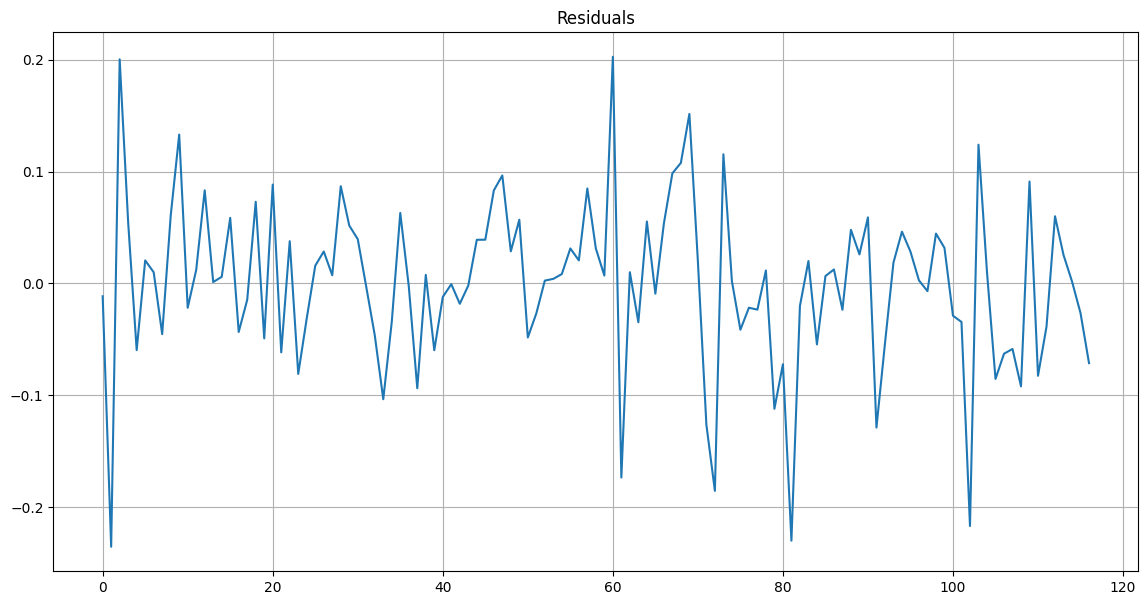

<Figure size 1400x700 with 0 Axes>

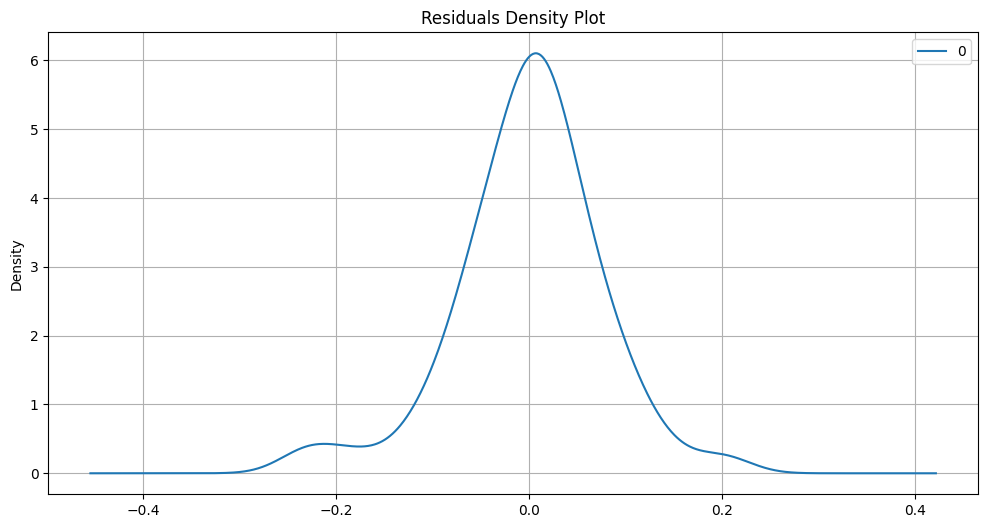

Residuals Summary Statistics:
                0
count  117.000000
mean    -0.000505
std      0.075359
min     -0.235348
25%     -0.038552
50%      0.005923
75%      0.039625
max      0.202626

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.022669  0.880322
2         0.030185  0.985021
3         0.156683  0.984259
4         0.206255  0.995034
5         0.214945  0.998945
6         0.840374  0.990947
7         1.728599  0.973326
8         2.808622  0.945787
9         6.395200  0.699806
10       10.143463  0.427998

Shapiro-Wilk Test for Normality:
Test Statistic: 0.9637035654716515
p-value: 0.0029762371753940028
Residuals do not appear to be normally distributed


In [11]:
validate_model(seasonal_arima)

In [37]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

def test_arima_on_holdout(data, end_column_name, exg_column_name, train_size=0.8, order=(0, 0, 0), seasonality='SEASONAL'):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    model = ARIMA(endog=train[end_column_name], exog=train[exg_column_name], order=order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test), exog=test[exg_column_name])
    results = pd.DataFrame({
        'Actual': test[end_column_name].values,
        'Predicted': forecast.values
    }, index=test.index)
    
    print('top 5 predictions:', results.head())
    print()
    print('last 5 predictions:', results.tail())
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train[end_column_name], label='Training Data')
    plt.plot(test.index, results['Actual'], label='Actual Test Data')
    plt.plot(test.index, results['Predicted'], label='Forecast', color='red')
    plt.title(f'{seasonality} DIFFERENCED ARIMA Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel(end_column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(results['Actual'], results['Predicted'])
    mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    return results, model_fit

Missing values before handling: avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64
Missing values after handling: avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64
top 5 predictions:                 Actual   Predicted
date                              
2022-03-22  206.222222  231.589922
2022-04-18  246.444444  272.406334
2022-04-22  287.555556  286.212286
2022-05-24  367.555556  310.463895
2022-06-26  423.111111  311.835139

last 5 predictions:                 Actual   Predicted
date                              
2023-09-01  280.000000  256.573127
2023-10-02  296.888889  259.703949
2023-11-01  302.666667  262.876467
2023-12-01  299.000000  261.946347
2024-01-01  309.222222  257.822526


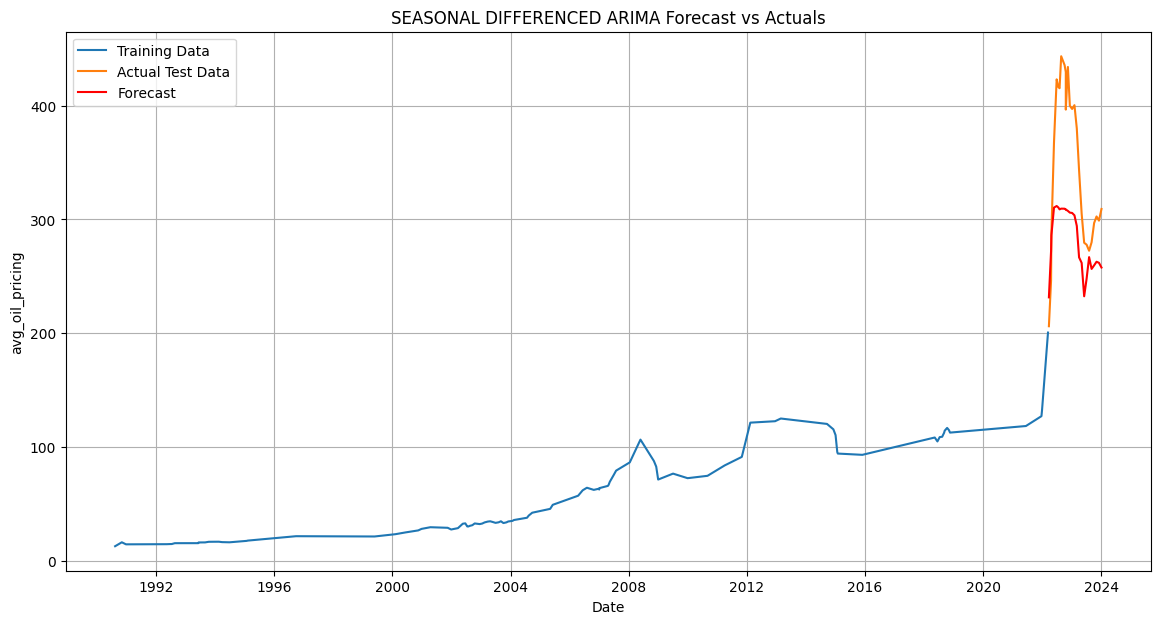

Mean Squared Error (MSE): 6303.999013053394
Root Mean Squared Error (RMSE): 79.39772674991013
Mean Absolute Error (MAE): 68.74741867409405
Mean Absolute Percentage Error (MAPE): 18.351225017109442%


In [38]:
data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_arima_on_holdout(data_missing_values_handled, ts_end_column, ts_exg_column, order = (4, 0, 4))

Missing values before handling: avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64
Missing values after handling: avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64
top 5 predictions:                 Actual   Predicted
date                              
2022-03-22  206.222222  238.194005
2022-04-18  246.444444  278.602533
2022-04-22  287.555556  304.169259
2022-05-24  367.555556  329.918247
2022-06-26  423.111111  329.652202

last 5 predictions:                 Actual   Predicted
date                              
2023-09-01  280.000000  268.326285
2023-10-02  296.888889  271.955149
2023-11-01  302.666667  275.560472
2023-12-01  299.000000  274.632389
2024-01-01  309.222222  269.817657


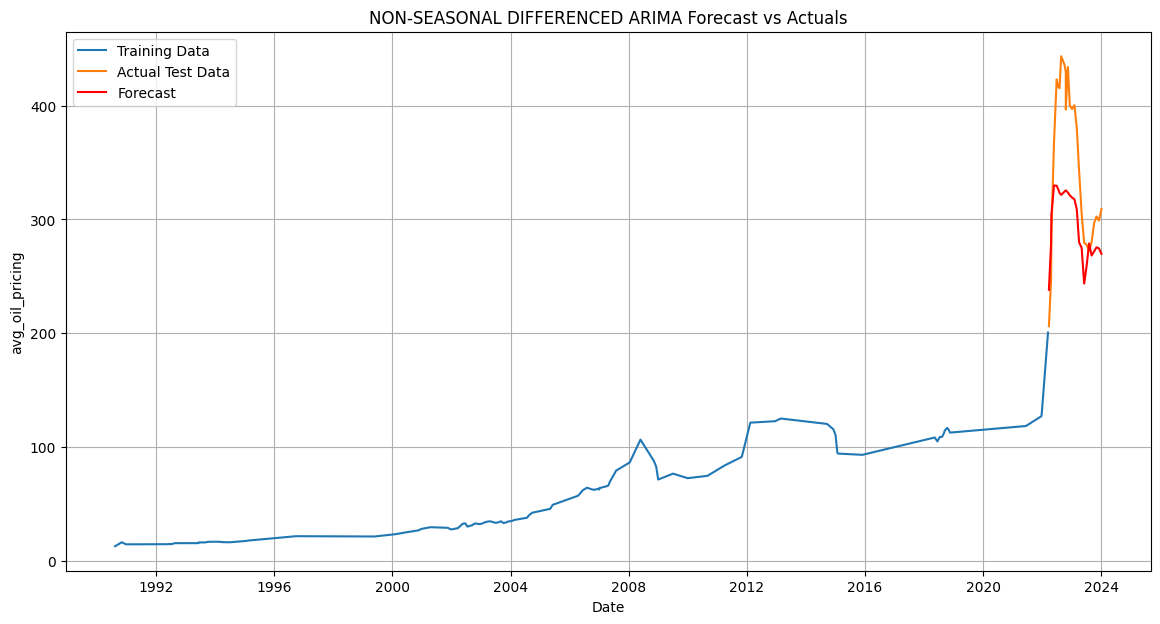

Mean Squared Error (MSE): 4565.57968888826
Root Mean Squared Error (RMSE): 67.56907346477573
Mean Absolute Error (MAE): 57.88099162278771
Mean Absolute Percentage Error (MAPE): 15.476349502483341%


In [56]:
data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_arima_on_holdout(data_missing_values_handled, ts_end_column, ts_exg_column, order = (4, 0, 5), seasonality='NON-SEASONAL')

In [47]:
def forecast_future(
        model, 
        steps, 
        usd_exchange_rates,
        original_index, 
        frequency='D',  # daily (M for monthly),
        seasonality='SEASONAL'
    ): 
    forecast = model.forecast(steps=steps, exog=usd_exchange_rates)
    last_date = original_index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq=frequency)
    forecast_df = pd.DataFrame(
        {
            'Forecast': forecast
        }, 
        index=forecast_dates
    )
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title(f'{seasonality} ARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    pred_conf = model.get_forecast(steps=steps, exog=usd_exchange_rates).conf_int()
    lower_conf = pred_conf[:, 0]
    upper_conf = pred_conf[:, 1]
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
        lower_conf,
        upper_conf,
        color='pink', 
        alpha=0.3, 
        label='95% Confidence Interval'
    )
    plt.title(f'{seasonality} ARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    forecast_df['Lower CI'] = lower_conf
    forecast_df['Upper CI'] = upper_conf
    return forecast_df

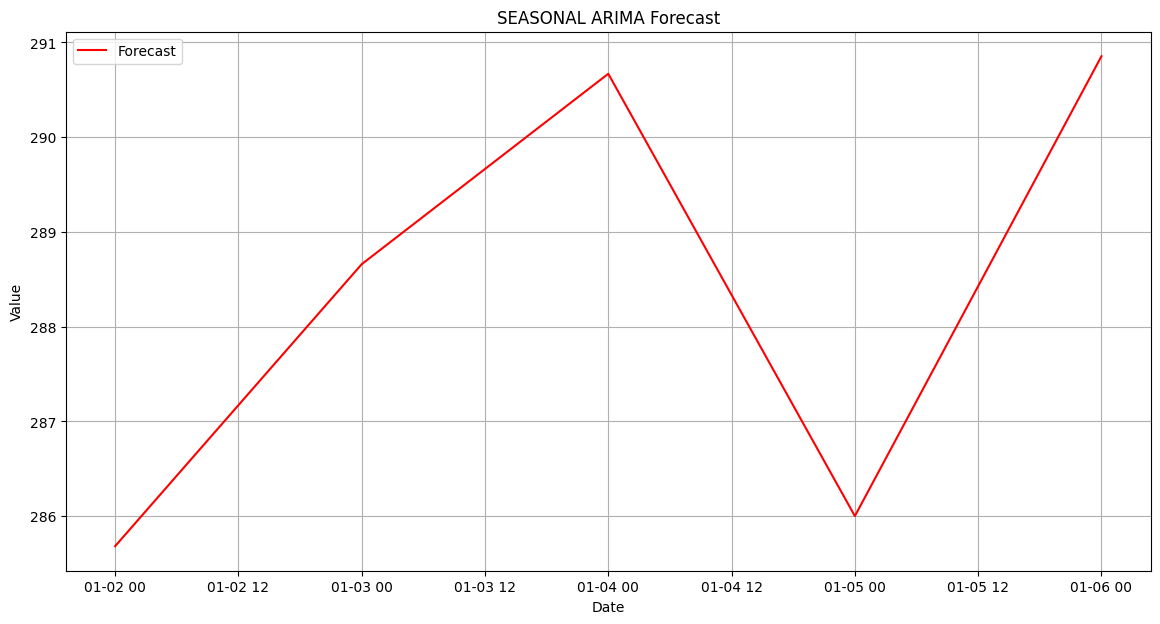

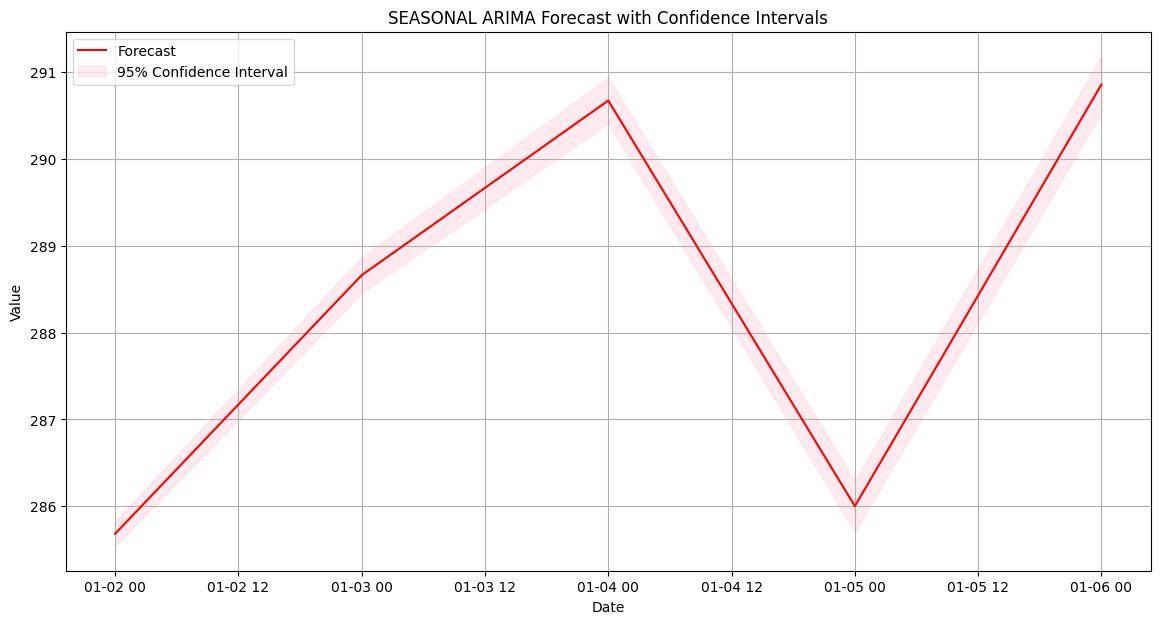

,Forecast,Lower CI,Upper CI
2024-01-02,285.683572,285.540756,285.826388
2024-01-03,288.659563,288.452370,288.866756
2024-01-04,290.669174,290.405886,290.932462
2024-01-05,286.001645,285.709344,286.293945
2024-01-06,290.854252,290.529153,291.179350


In [48]:
forecast_df = forecast_future(seasonal_arima, 5, [300, 303, 305, 300, 305], data.index)
forecast_df.head()

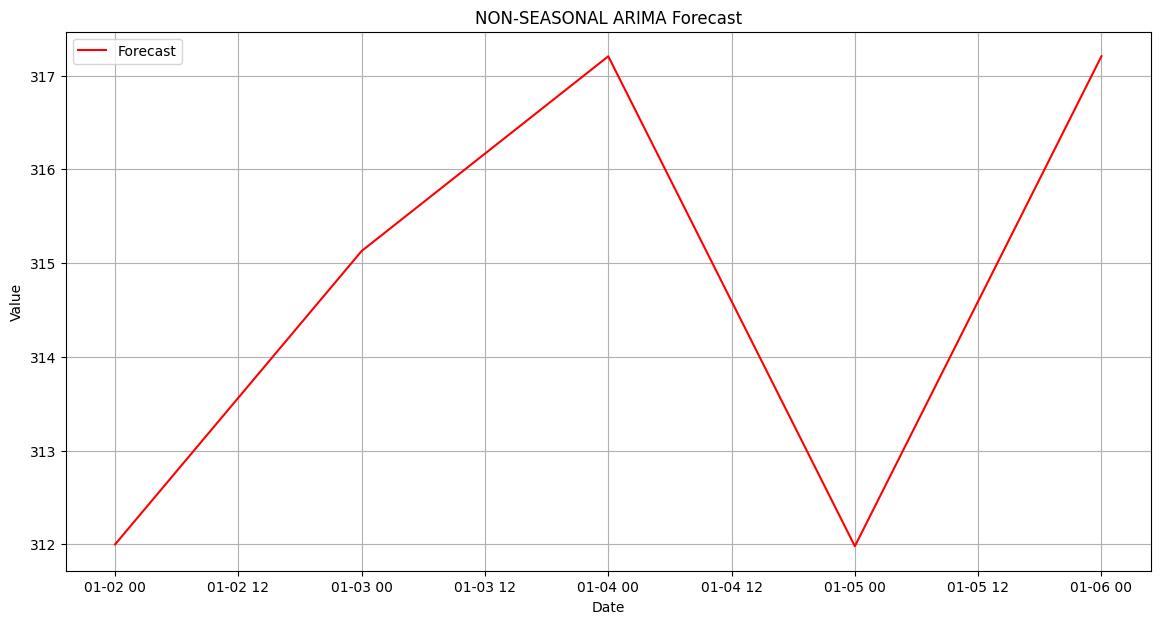

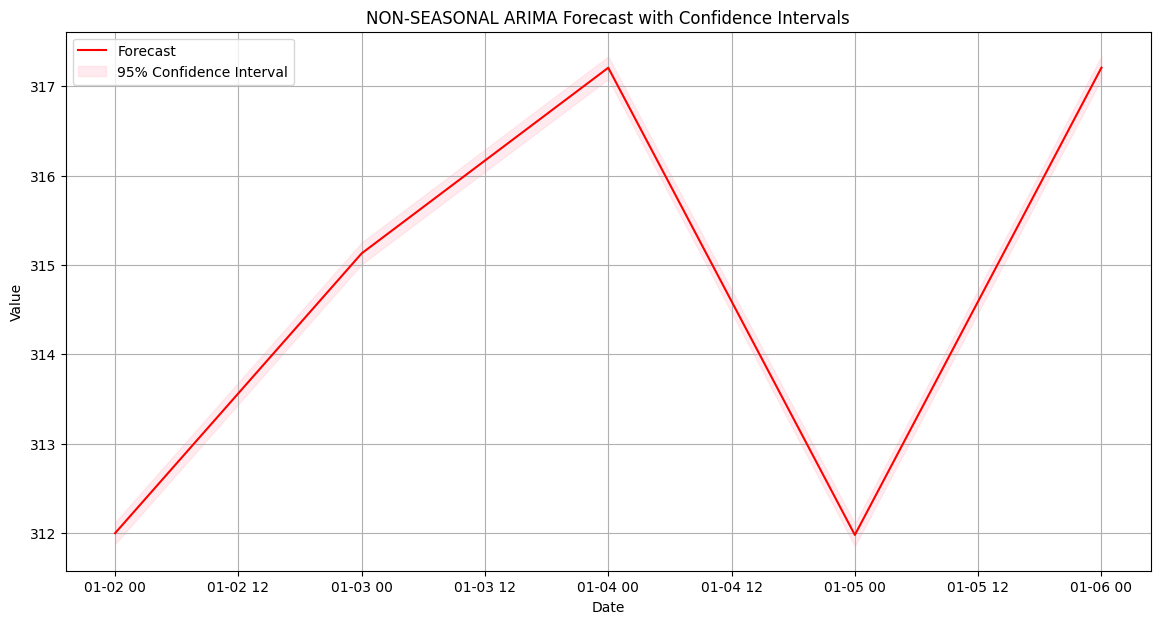

,Forecast,Lower CI,Upper CI
2024-01-02,311.999219,311.877969,312.120470
2024-01-03,315.129432,315.007379,315.251486
2024-01-04,317.205811,317.079585,317.332036
2024-01-05,311.979848,311.853478,312.106218
2024-01-06,317.206693,317.078793,317.334593


In [55]:
forecast_df = forecast_future(non_seasonal_arima, 5, [300, 303, 305, 300, 305], data.index, seasonality='NON-SEASONAL')
forecast_df.head()

## Seasonal ARIMA (SARIMA)

Extends ARIMA to handle seasonal components. The model is denoted as `SARIMA(p,d,q)(P,D,Q,s)` where:<br>
- `p,d,q`: Non seasonal components
- `P,D,Q`: Seasonal components
- `s`: Seasonality period (eg. 12 for monthly data)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  128
Model:               SARIMAX(4, 0, 5)   Log Likelihood                 171.460
Date:                Thu, 05 Jun 2025   AIC                           -320.921
Time:                        19:01:50   BIC                           -289.548
Sample:                             0   HQIC                          -308.174
                                - 128                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0933      0.133      8.202      0.000       0.832       1.355
ar.L1         -0.0234      0.243     -0.096      0.923      -0.499       0.452
ar.L2          0.4838      0.162      2.987      0.0

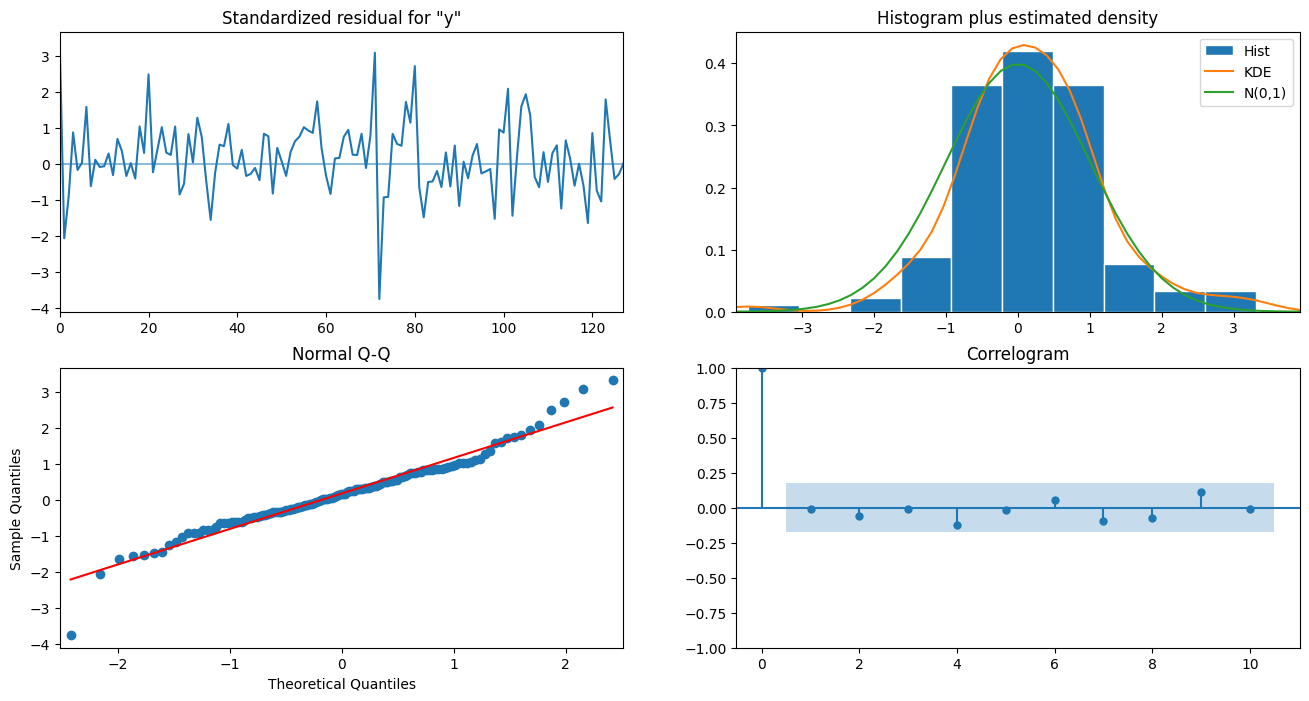

In [5]:
def fit_sarima_model(endog, exog, order, seasonal_order):
    model = SARIMAX(endog, exog, order=order, seasonal_order=seasonal_order)

    results = model.fit()
    print(results.summary())

    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    return model

sarima = fit_sarima_model(
    endog=ts_end_diff, 
    exog=ts_exg_diff, 
    order=(4, 0, 5), 
    seasonal_order=(0, 0, 0, 12)
)

In [14]:
def optimize_sarimax_parameters(endog, exog, p, d, q, P_range, D_range, Q_range, s):
    best_aic = float("inf")
    best_params = None
    best_model = None
    
    total_iterations = len(P_range) * len(D_range) * len(Q_range)
    print(f"Testing {total_iterations} SARIMAX configurations with seasonal={s}")
    
    counter = 0
    for P in P_range:
        for D in D_range:
            for Q in Q_range:
                counter += 1
                if counter % 10 == 0:
                    print(f"Progress: {counter}/{total_iterations} configurations tested")
                    
                # Skip if all parameters are 0
                if p + d + q + P + D + Q == 0:
                    continue
                    
                try:
                    model = SARIMAX(
                        endog,
                        exog,
                        order=(p, d, q),
                        seasonal_order=(P, D, Q, s),
                        enforce_stationarity=False,
                        enforce_invertibility=False
                    )
                    results = model.fit(disp=False, maxiter=200)
                    
                    if results.aic < best_aic:
                        best_aic = results.aic
                        best_params = (p, d, q, P, D, Q, s)
                        best_model = results
                        print(f"SARIMA({p},{d},{q})({P},{D},{Q},{s}) - AIC: {results.aic:.4f}")
                except:
                    continue
    
    if best_model is not None:
        print(f"\nBest SARIMA{best_params} model - AIC: {best_aic:.4f}")
    else:
        print("No suitable SARIMAX model found.")
        
    return best_model, best_params

sarima, params = optimize_sarimax_parameters(
    endog=ts_end_diff, 
    exog=ts_exg_diff, 
    p=4, 
    d=0, 
    q=4, 
    P_range=range(0, 6), 
    D_range=range(0, 2), 
    Q_range=range(0, 6), 
    s=12
)

Testing 72 SARIMAX configurations with seasonal=12
SARIMA(4,0,4)(0,0,0,12) - AIC: -320.9674
Progress: 10/72 configurations tested
Progress: 20/72 configurations tested
Progress: 30/72 configurations tested
Progress: 40/72 configurations tested
Progress: 50/72 configurations tested
Progress: 60/72 configurations tested
Progress: 70/72 configurations tested

Best SARIMA(4, 0, 4, 0, 0, 0, 12) model - AIC: -320.9674


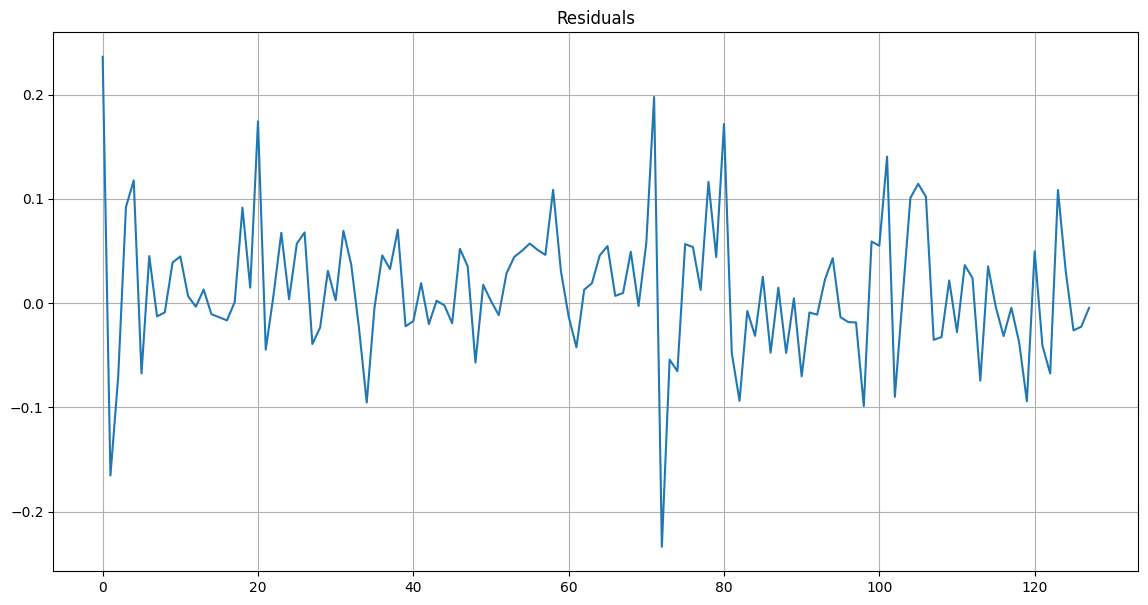

<Figure size 1400x700 with 0 Axes>

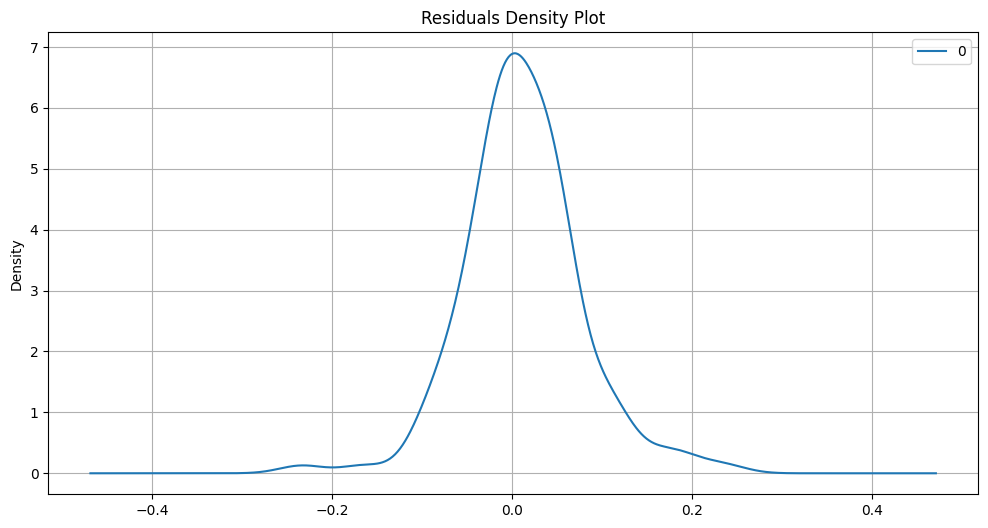

Residuals Summary Statistics:
                0
count  128.000000
mean     0.012056
std      0.064901
min     -0.233841
25%     -0.022397
50%      0.006763
75%      0.045866
max      0.236313

Ljung-Box Test Results:
    Test Statistic   p-value
1         0.339987  0.559837
2         1.781678  0.410311
3         2.013759  0.569556
4         2.219748  0.695416
5         2.433724  0.786442
6         2.771267  0.836959
7         2.884496  0.895478
8         4.742281  0.784733
9         5.664907  0.772931
10        5.670879  0.842115

Shapiro-Wilk Test for Normality:
Test Statistic: 0.9615345972466772
p-value: 0.0010880480271887227
Residuals do not appear to be normally distributed


In [15]:
validate_model(sarima)

Missing values before handling: avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64
Missing values after handling: avg_oil_pricing      0
usd_exchange_rate    0
dtype: int64
top 5 predictions:                 Actual   Predicted
date                              
2022-03-22  206.222222  235.594780
2022-04-18  246.444444  271.566528
2022-04-22  287.555556  294.016537
2022-05-24  367.555556  318.727440
2022-06-26  423.111111  320.936216

last 5 predictions:                 Actual   Predicted
date                              
2023-09-01  280.000000  283.247947
2023-10-02  296.888889  286.236625
2023-11-01  302.666667  290.466204
2023-12-01  299.000000  291.539862
2024-01-01  309.222222  288.242103


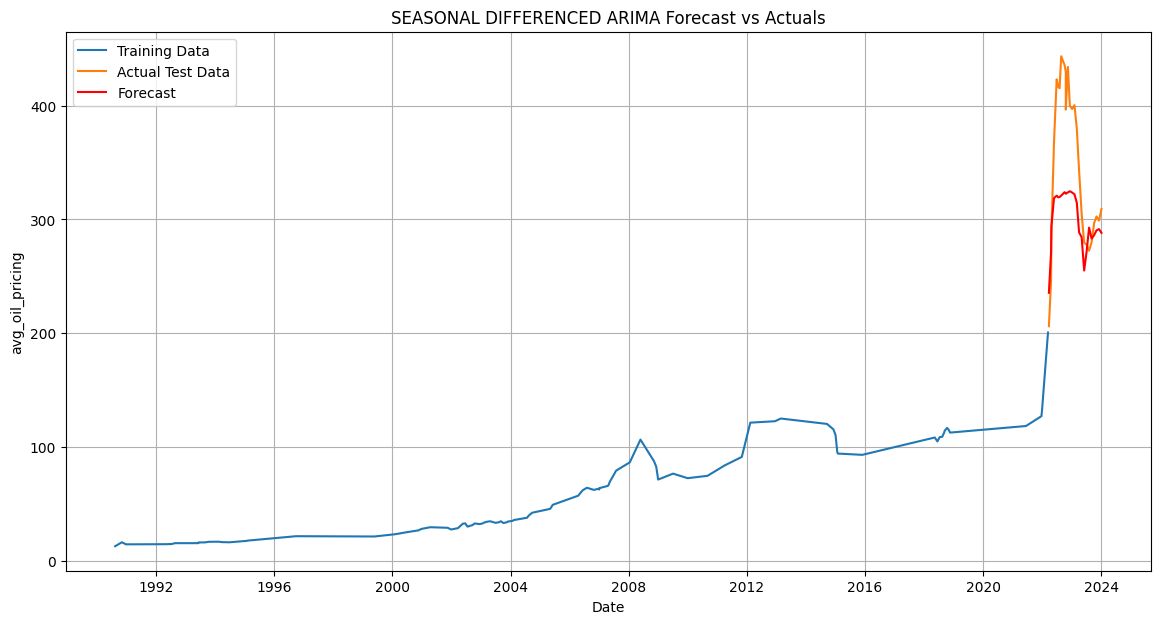

Mean Squared Error (MSE): 4461.132874872506
Root Mean Squared Error (RMSE): 66.79171262119655
Mean Absolute Error (MAE): 53.93420706254362
Mean Absolute Percentage Error (MAPE): 14.065276530413099%


In [16]:
def handle_missing_values(data):
    missing_values = data.isnull().sum()
    print(f"Missing values before handling: {missing_values}")
    
    # Time-based interpolation
    data_time_interp = data.interpolate(method='time')
    missing_values = data_time_interp.isnull().sum()
    print(f"Missing values after handling: {missing_values}")
    return data_time_interp

def test_sarima_on_holdout(data, end_column_name, exg_column_name, order, seasonal_order, train_size=0.8, seasonality='SEASONAL'):
    train_size = int(len(data) * train_size)
    train, test = data[:train_size], data[train_size:]
    model = SARIMAX(endog=train[end_column_name], exog=train[exg_column_name], order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    
    forecast = model_fit.forecast(steps=len(test), exog=test[exg_column_name])
    results = pd.DataFrame({
        'Actual': test[end_column_name].values,
        'Predicted': forecast.values
    }, index=test.index)
    
    print('top 5 predictions:', results.head())
    print()
    print('last 5 predictions:', results.tail())
    
    # Plot actual vs forecast
    plt.figure(figsize=(14, 7))
    plt.plot(train[end_column_name], label='Training Data')
    plt.plot(test.index, results['Actual'], label='Actual Test Data')
    plt.plot(test.index, results['Predicted'], label='Forecast', color='red')
    plt.title(f'{seasonality} DIFFERENCED ARIMA Forecast vs Actuals')
    plt.xlabel('Date')
    plt.ylabel(end_column_name)
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(results['Actual'], results['Predicted'])
    rmse = sqrt(mse)
    mae = mean_absolute_error(results['Actual'], results['Predicted'])
    mape = np.mean(np.abs((results['Actual'] - results['Predicted']) / results['Actual'])) * 100
    print(f'Mean Squared Error (MSE): {mse}')
    print(f'Root Mean Squared Error (RMSE): {rmse}')
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'Mean Absolute Percentage Error (MAPE): {mape}%')
    return results, model_fit

data_missing_values_handled = handle_missing_values(data)
results, model_fit = test_sarima_on_holdout(data_missing_values_handled, ts_end_column, ts_exg_column, (4, 0, 5), (0, 0, 0, 12))

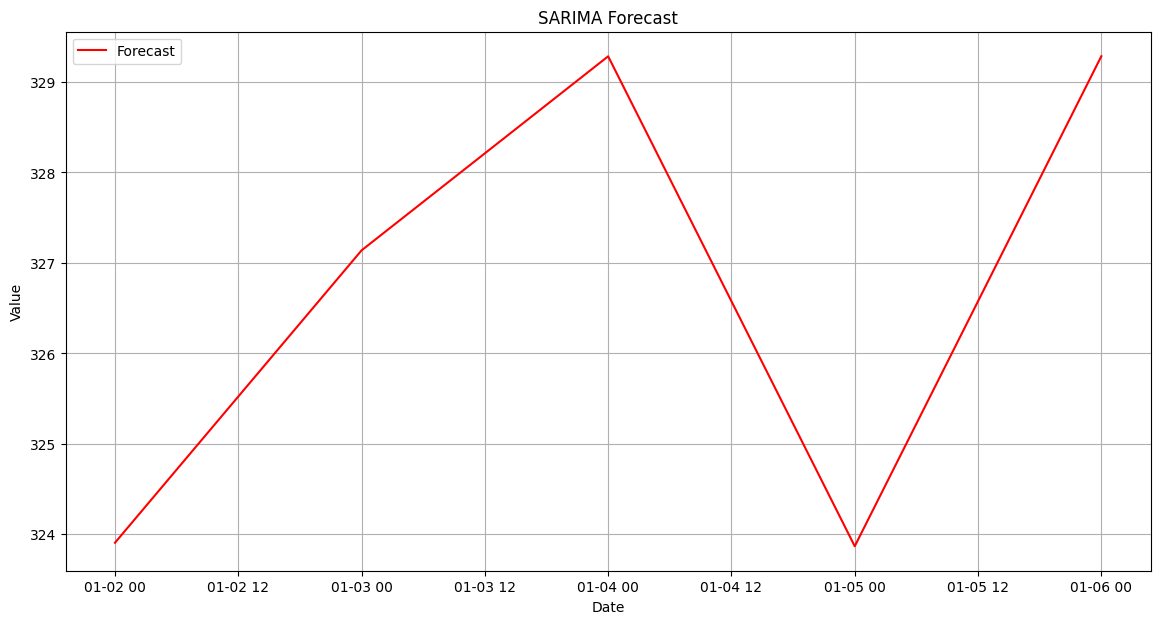

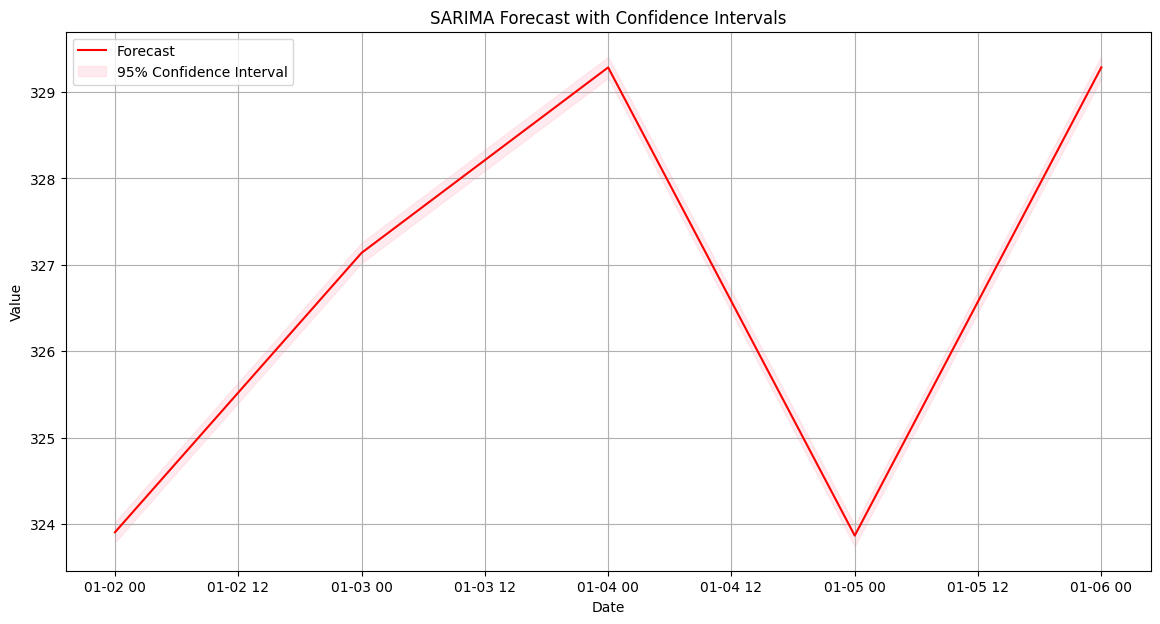

,Forecast,Lower CI,Upper CI
2024-01-02,323.906940,323.790214,324.023665
2024-01-03,327.138704,327.020932,327.256477
2024-01-04,329.283675,329.160755,329.406594
2024-01-05,323.868571,323.745643,323.991499
2024-01-06,329.284683,329.156094,329.413272


In [17]:
def forecast_future(
        model, 
        steps, 
        usd_exchange_rates,
        original_index, 
        frequency='D',  # daily (M for monthly)
    ): 
    forecast = model.forecast(steps=steps, exog=usd_exchange_rates)
    last_date = original_index[-1]
    forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=steps, freq=frequency)
    forecast_df = pd.DataFrame(
        {
            'Forecast': forecast
        }, 
        index=forecast_dates
    )
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.title('SARIMA Forecast')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    pred_conf = model.get_forecast(steps=steps, exog=usd_exchange_rates).conf_int()
    lower_conf = pred_conf[:, 0]
    upper_conf = pred_conf[:, 1]
    plt.figure(figsize=(14, 7))
    # plt.plot(original_index_aligned, historical_data_aligned, label='Historical Data')
    plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
    plt.fill_between(forecast_df.index,
        lower_conf,
        upper_conf,
        color='pink', 
        alpha=0.3, 
        label='95% Confidence Interval'
    )
    plt.title('SARIMA Forecast with Confidence Intervals')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    forecast_df['Lower CI'] = lower_conf
    forecast_df['Upper CI'] = upper_conf
    return forecast_df

forecast_df = forecast_future(sarima, 5, [300, 303, 305, 300, 305], data.index)
forecast_df.head()

### Final thought

- Best ARIMA (with seasonally non differenced data): `p=4, d=0, q=4`
- Best ARIMA (with seasonally differenced data): `p=4, d=0, q=5`
- Best SARIMA: `p=4, d=0, q=4, P=0, D=0, Q=0, s=12`